
# I'm Something of a Painter Myself

Kaggle Competition Notebook: https://www.kaggle.com/competitions/gan-getting-started/overview


## Step One: Project Overview


In this project, we want to build a model that will allow us to transform a real image into a monet-stylized version of the image. To do this we can build a CycleGAN to train a generator, then use the generator to transform the real image.
A Generative Adversarial Network (GAN) is a type of deep learning model that is typically used to generate data that mimics data from the input set. 
Typically a GAN is made up of two neural networks including a generator and a discriminator. 
Generally speaking, there is an input dataset of "real" data and a set of "fake" data, generated by the generator, that is fed to the discriminator, whose job is to classify the data as being real or fake. 

Training is basically the two networks playing a game against each other (hence the 'adversarial' part of GAN). The discriminator's goal is to learn how to reliably pick the real image, while the generator's goal is to fool the generator so it picks the fake image. At the beginning of training generators are really producing random noise and the discriminator is making random guesses. But as training continues, the results of who wins/loses is fed back to each model to help it learn how to either pick images better or generate images better. The process continues until the generator is able to reliably fool the discriminator. 

### Helpful resources: 
- https://www.tensorflow.org/tutorials/generative/cyclegan
- https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py
- https://www.geeksforgeeks.org/cycle-generative-adversarial-network-cyclegan-2/
- https://www.youtube.com/watch?v=_qB4B6ttXk8
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook


## Step Two: Exploratory Data Analysis & Data Preparation

In this section I will load the data from kaggle and then spend some time exploring the images we have available to get a better understanding of the images and how to build a model that can ingest these images. 

### Loading Kaggle Data

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.6.4


In [2]:
dataset_path = KaggleDatasets().get_gcs_path()
print(f"Path is: {dataset_path}")

Path is: gs://kds-e3bc68da5fa153f970a356273299b67ff39f11feb0b0e8ed12947d32


The above dataset has 4 different directories with data:
- `monet_jpg` and `photo_jpg` contain `.jpg` images that we can use to build and train the model that we'll use to generate images from
- The `photo_tfrec` and `monet_tfrec` directories contain [TFRecord files](https://www.tensorflow.org/tutorials/load_data/tfrecord/)

Next we can load the data to see how it is structured - for this section I used Amy Jang's [tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) to help understand how to load the data. 

In [3]:
import matplotlib.pyplot as plt
import os

monet_dir = f'{dataset_path}/monet_jpg'
photo_dir = f'{dataset_path}/photo_jpg'
monet_rec_dir = f'{dataset_path}/monet_tfrec'
photo_rect_dir = f'{dataset_path}/photo_tfrec'

IMAGE_SIZE = [256, 256]
OUTPUT_CHANNELS = 3

# Records contain the image_name, image and target
def parse_record_and_image(record):
    features = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_record = tf.io.parse_single_example(record, features)
    # Process image
    image = tf.image.decode_jpeg(parsed_record['image'], channels=3) 
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def load_images(tfrec_dir: str):
    tfrecord_files = tf.io.gfile.glob(os.path.join(tfrec_dir, "*.tfrec"))
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    return dataset.map(parse_record_and_image, num_parallel_calls=AUTOTUNE)    


In [4]:
monet_data = load_images(monet_rec_dir).batch(1)
photo_data = load_images(photo_rect_dir).batch(1)

## Data Visualization & Analysis

Now that the data is loaded we can take a look at what the photo vs monet images look like to get an idea for what we'll need to build with the generator. In this section I display the input image as well as the image broken down into its RGB channels so that we can take a look at how each image is distributed.

In [5]:
# Image Helpers: 
import seaborn as sns
from matplotlib.gridspec import GridSpec

def show_image_basic(image, title=None):
    plt.axis('off')
    if title:
        plt.gca().set_title(title)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().imshow(image*0.5+0.5)

def show_multiple_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i, image in enumerate(dataset.take(num_images)):
        axes[i].imshow(image[0] * 0.5 + 0.5)  # Rescale the image back to [0, 1]
        axes[i].axis('off')
    plt.show()

def show_image_by_channel(image, show_dist:bool = False):
    channels = {
        'red': image[:,:,0],
        'green':image[:,:,1],
        'blue':image[:,:,2],
    }
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(3, 3, width_ratios=[1, 1, 1], height_ratios=[1, 0.5, 0.5])
    ax_kde = fig.add_subplot(gs[1, :])
    # Plot images in the top row
    for i, channel in enumerate(channels):
        ax_img = fig.add_subplot(gs[0, i])
        ax_img.imshow(channels[channel], cmap=channel.capitalize()+"s")
        ax_img.set_title(f'{channel.capitalize()} Channel')
        ax_img.axis('off')

        channel_data = channels[channel].numpy().ravel()
        sns.kdeplot(channel_data, color=channel, ax=ax_kde)
        
        if show_dist:
            ax_hist = fig.add_subplot(gs[2, i])
            ax_hist.hist(channel_data, bins=64, range=(-1, 1), color=channel, alpha=0.5)
            ax_hist.grid(True, alpha=0.5)
            ax_hist.set_yticklabels([])
            
            ax_kde.set_title('Pixel Density by Channel')
            ax_kde.set_xlabel('Pixel Value')
            ax_kde.set_ylabel('Density')
            ax_kde.legend([f'{channel.capitalize()} Channel' for channel in channels])
            ax_kde.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()


### Photo Images

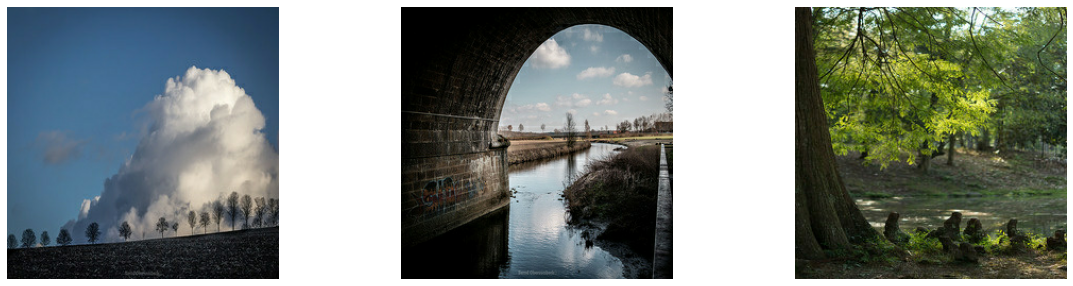

In [6]:
show_multiple_images(photo_data, num_images = 3)

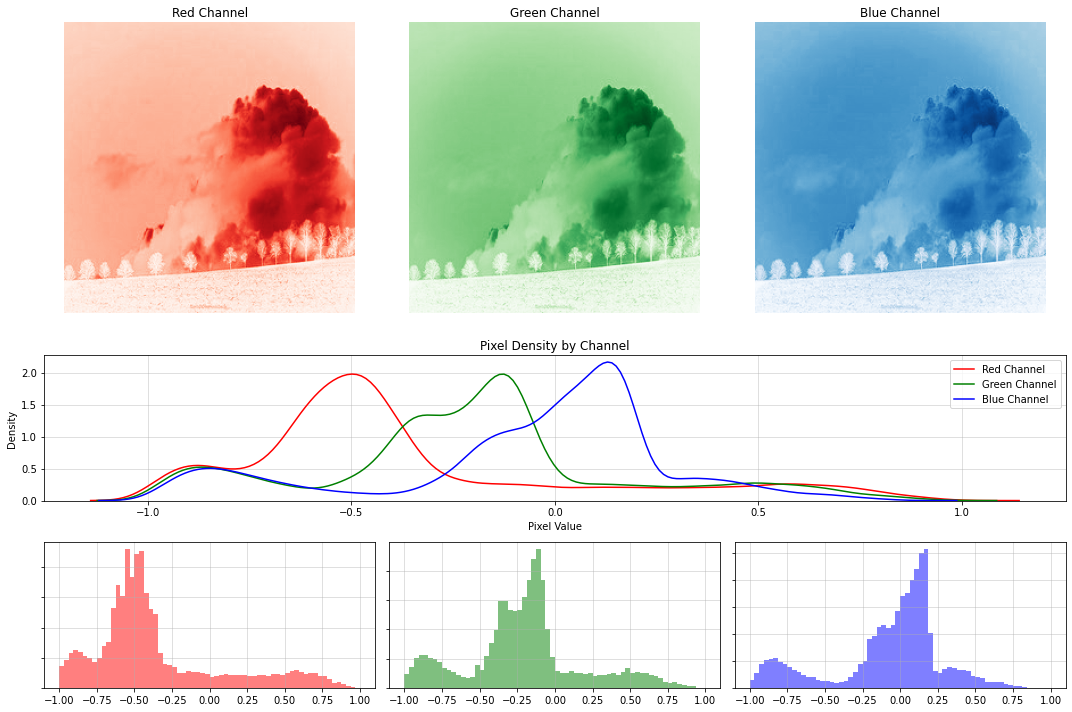

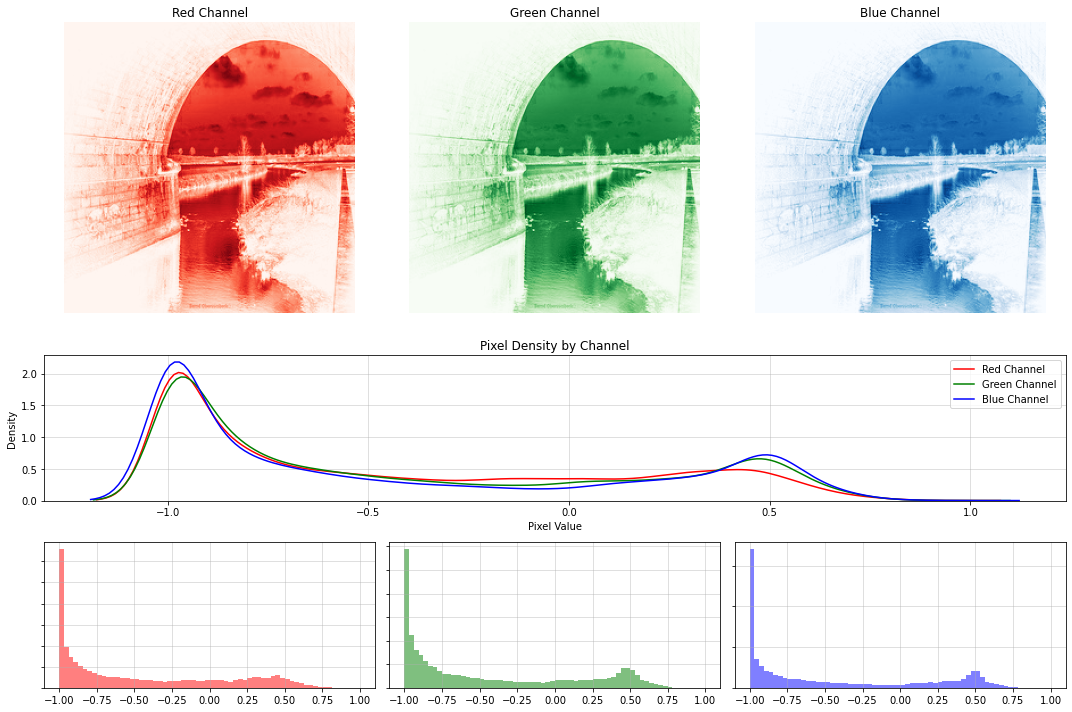

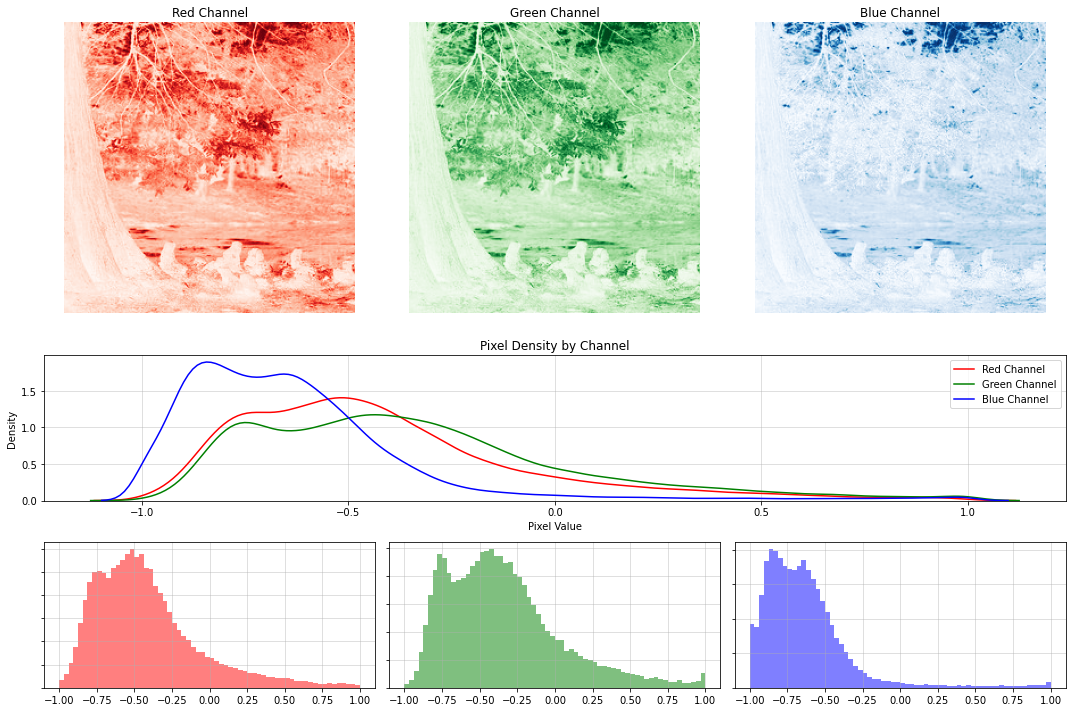

In [7]:
for i, image in enumerate(photo_data.take(3)):
    show_image_by_channel(image[0], show_dist = True)

### Monet Images

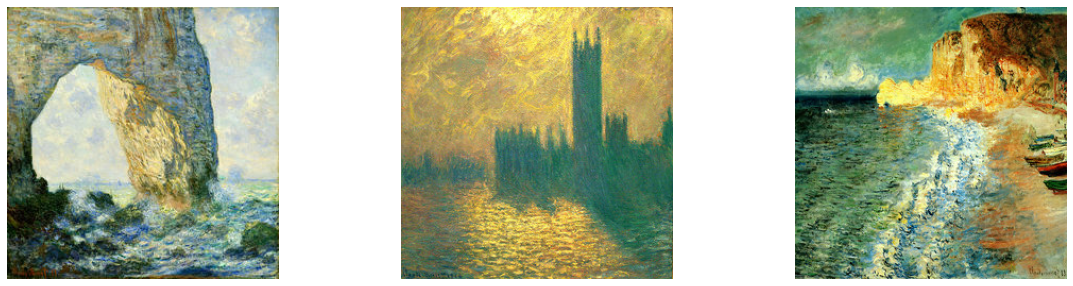

In [8]:
show_multiple_images(monet_data, num_images = 3)

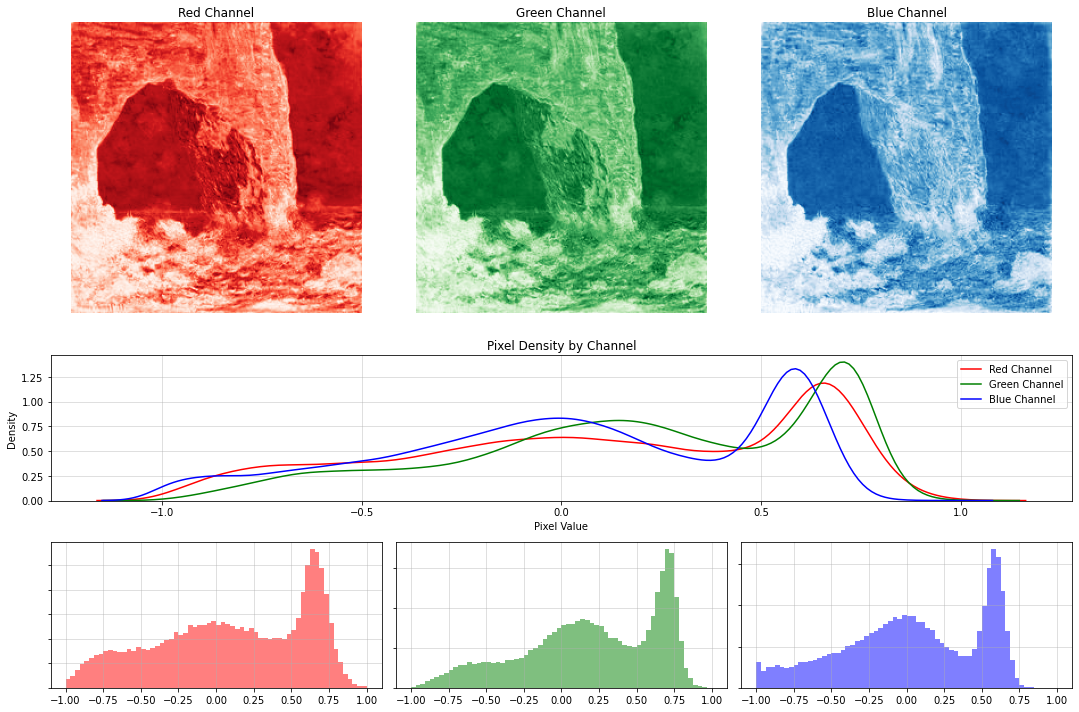

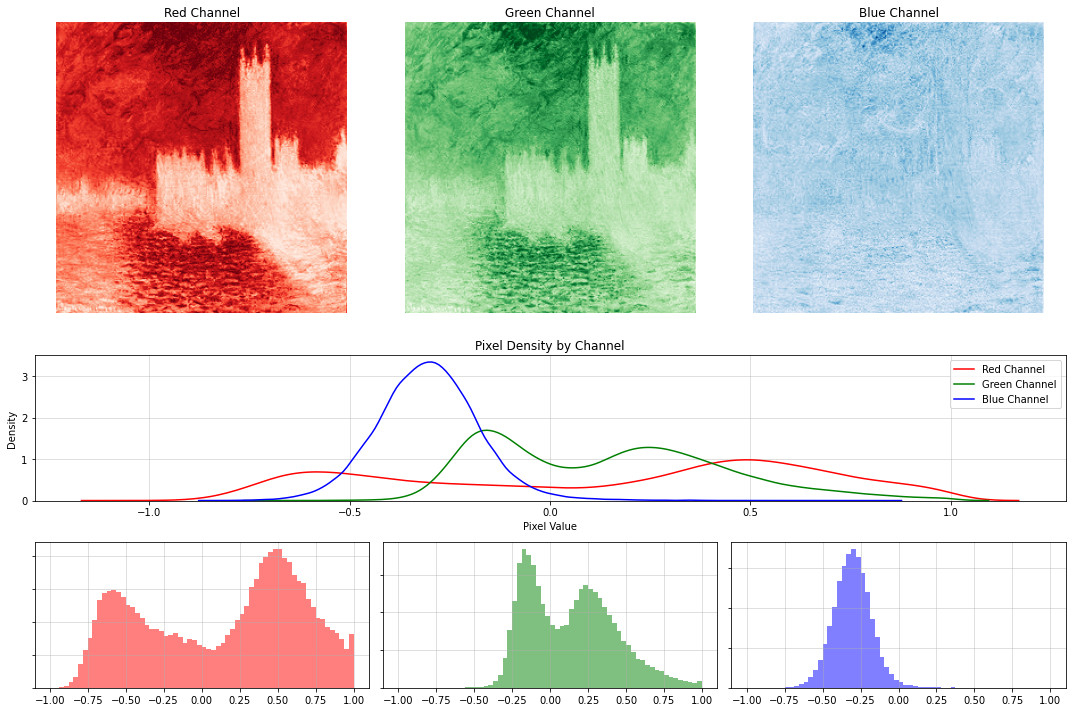

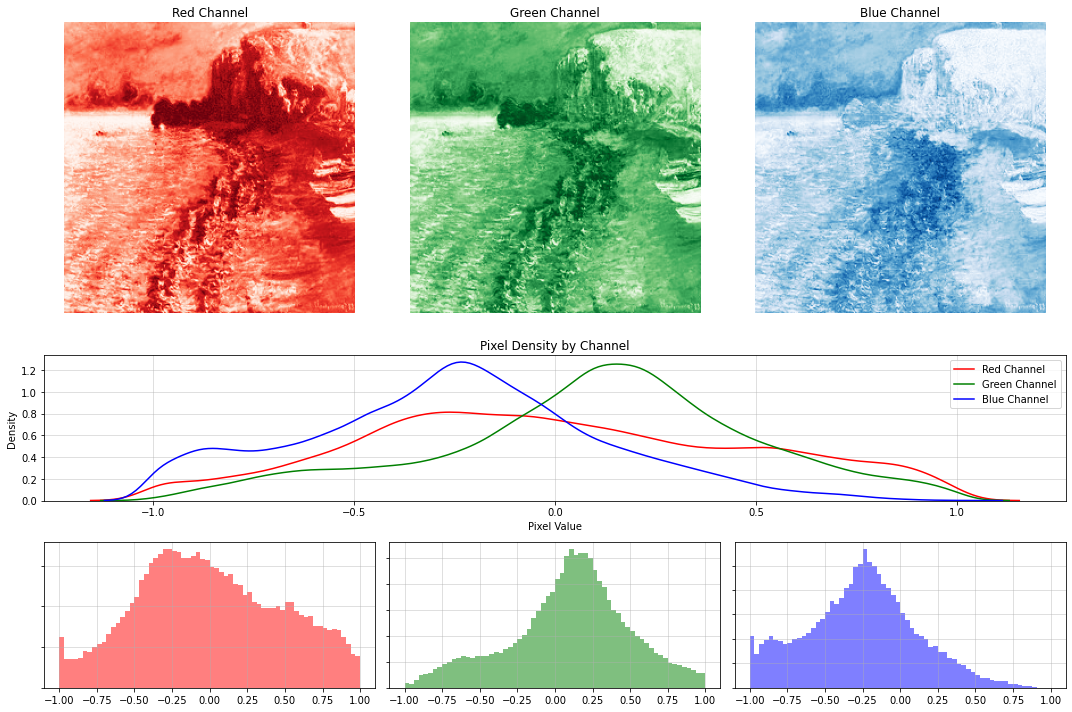

In [9]:
for i, image in enumerate(monet_data.take(3)):
    show_image_by_channel(image[0], show_dist = True)

## Step Three: Model Architecture

For this project the ideas is that we want to extract features from one image and transfer them to another image. In this section of the notebook I'll be focusing on implementing a Generator and Discriminator so we can train them with the CycleGAN model suggested in the tutorial. 
As indicated in the tutorial - CycleGANs are a commonly used approach for performing image feature transformations.
To implement this, I will utilize a U-Net generator architecture and a PatchGAN discriminator. U-Net generators is known for its ability to capture fine details in the generated images, making it suitable for tasks requiring high-quality image translation. The PatchGAN discriminator focuses on local image patches, providing detailed feedback to the generator and encouraging the production of realistic-looking images.
To guide my implementation, I have referenced [this page](https://www.geeksforgeeks.org/cycle-generative-adversarial-network-cyclegan-2/), which provides a comprehensive overview of U-Net generators and PatchGAN discriminators. Additioanlly, I'll be leaning on the CycleGAN implementation from Amy Jang's previously referenced tutorial notebook so that I can focus on building effective generator and discriminator models. 


## Generator Definition


To kick off the model construction, I'll begin by defining the generator neural network. I've implemented a helper function called `block`, using the tutorial as a reference. For this generator, I'm opting for a U-Net architecture. This approach involves downsampling the layers for a few iterations and then upsampling them again. The generator can typically be broken up into 3 sections, the encoder, transformer, and decoder. I'll also include a flag to control the skip connections, allowing us to assess their significance later on. For additional context, I used [this reference](https://www.geeksforgeeks.org/cycle-generative-adversarial-network-cyclegan-2/), to help pick the number of filters, filter sizes, and stride values to include in the model.

In [10]:
def block(filters, size,  stride:int = 2, increase:bool = False, apply_instancenorm=True, apply_dropout=False):
    result = keras.Sequential()
    if increase: 
        result.add(layers.Conv2DTranspose(filters, size, strides=stride,
                                  padding='same',
                                  kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                  use_bias=False))

        result.add(tfa.layers.InstanceNormalization())

        if apply_dropout:
            result.add(layers.Dropout(0.5))
    else:
        result.add(layers.Conv2D(filters, size, strides=stride, padding='same',
                                 kernel_initializer=tf.random_normal_initializer(0., 0.02), use_bias=False))

        if apply_instancenorm:
            result.add(tfa.layers.InstanceNormalization())

    result.add(layers.LeakyReLU())

    return result

In [11]:
def Generator(depth: int =5, do_skip: bool = True, activation:str = 'tanh'):
    encoder_layers = [
        block(64, 7, apply_instancenorm=False),
        block(128, 3), 
        block(256, 3), 
    ]
    
    decoder_layers = [
        block(256, 3, increase=True),
        block(128, 3, increase=True),
        block(64, 7, increase=True),
    ]
    
    # Build Transform Layers of UNET 
    transform_decrease = [block(256, 3) for i in range(depth)]
    transform_increase = [block(256, 3, increase=True, apply_dropout=True) for i in range(depth - 2)] + [block(256, 3, increase=True)]
    
    
    decreasing_layers = encoder_layers + transform_decrease
    increasing_layers = transform_increase + decoder_layers
    skip_connections = []
    
    #Construct U-Net Architecture
    inputs = layers.Input(shape=[256,256,3])
    generator_layers = inputs
    
    for layer in decreasing_layers:
        # Append current layer to architecture
        generator_layers = layer(generator_layers)
        if do_skip:
            skip_connections.insert(0, generator_layers)
    
    if do_skip: 
        skip_connections = skip_connections[1:] # Remove inputs from list
        for layer, skip_con in zip(increasing_layers, skip_connections):
            generator_layers = layer(generator_layers)
            generator_layers = layers.Concatenate()([generator_layers, skip_con])
    else:
        for layer in increasing_layers:
            generator_layers = layer(generator_layers)
    
    output_layer = layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                              strides=2,
                              padding='same',
                              kernel_initializer=tf.random_normal_initializer(0., 0.02),
                              activation=activation)

    generator_layers = output_layer(generator_layers)
    return keras.Model(inputs=inputs, outputs=generator_layers)
Generator().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  73984       sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  295424      sequential_1[0][0]               
______________________________________________________________________________________________

### Untrained Generator Example:

The generator isn't trained yet but here we can assess the impact of omitting skip connections and using a sigmoid activation function instead of a tanh activation function: 

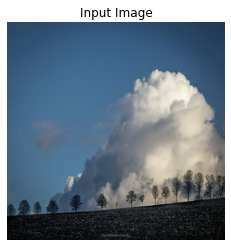

In [12]:
example_photo = next(iter(photo_data))
show_image_basic(example_photo[0], title= "Input Image")

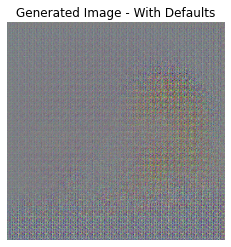

In [13]:
monet_generator = Generator()
to_monet = monet_generator(example_photo)

show_image_basic(to_monet[0], title= "Generated Image - With Defaults")

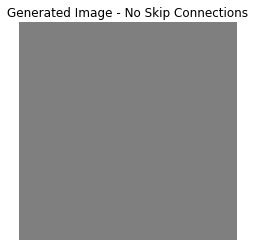

In [14]:
monet_generator = Generator(do_skip = False)
to_monet = monet_generator(example_photo)

show_image_basic(to_monet[0], title= "Generated Image - No Skip Connections")

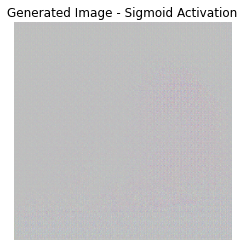

In [15]:
monet_generator = Generator(activation = 'sigmoid')
to_monet = monet_generator(example_photo)

show_image_basic(to_monet[0], title= "Generated Image - Sigmoid Activation")

## Discriminator Definition

Next, I'll construct the PatchGAN discriminator. This component's job is to help distinguish between a real and a fake/generated image. PatchGAN discriminators specifically work by breaking the image up into smaller sections (patches) and andicate if the sections themselves appear to be real or fake. This is achieved by downsampling the input image, allowing the discriminator to focus in on these individual patches and ultimately provide more granular feedback as the model is getting trained. 

In [16]:
def Discriminator():
    # PatchGAN Architecture
    initializer = tf.random_normal_initializer(0., 0.02)

    input_layer = layers.Input(shape=[256, 256, 3], name='input_image')

    discriminator_layers = input_layer
    layer_list = [
        block(64, 4, apply_instancenorm=False),
        block(128, 4),
        block(256, 4),
        layers.ZeroPadding2D(),
        layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False), 
        tfa.layers.InstanceNormalization(), 
        layers.LeakyReLU(), 
        layers.ZeroPadding2D(), 
        layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)
    ]

    for layer in layer_list:
        discriminator_layers = layer(discriminator_layers)

    return tf.keras.Model(inputs=input_layer, outputs=discriminator_layers)

Discriminator().summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_60 (Sequential)   (None, 128, 128, 64)      3072      
_________________________________________________________________
sequential_61 (Sequential)   (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_62 (Sequential)   (None, 32, 32, 256)       524800    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 256)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 31, 31, 512)       2097152   
_________________________________________________________________
instance_normalization_58 (I (None, 31, 31, 512)       1024

### Define the CycleGAN

For the actual CycleGAN we'll proceed with the implementation in [Amy Jang's tutorial ](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook): 

In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In order to use the Tutorial CycleGAN we'll also need to import the loss functions - additional information on the loss functions can be found [here](https://www.geeksforgeeks.org/cycle-generative-adversarial-network-cyclegan-2/). 

In [18]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

## Training


In the upcoming section, I'll initiate three training runs with different structures/parameters to be compared in the following section. I'll start by running the model with its default configuration, then I'll run it without skip connections, and finally, I'll run it using a different activation function. This will allow us to observe how these variations, with the same number of epochs, affect the model's output.

In [19]:
def build_and_train_cyclegan(epochs = 2, generator_args = {}):
    # Create generators and discriminators 
    monet_generator = Generator(**generator_args) # transforms photos to Monet-esque paintings
    photo_generator = Generator(**generator_args) # transforms Monet paintings to be more like photos
    monet_discriminator = Discriminator() 
    photo_discriminator = Discriminator()
        
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = tf.keras.optimizers.Adam(),
        p_gen_optimizer = tf.keras.optimizers.Adam(),
        m_disc_optimizer = tf.keras.optimizers.Adam(),
        p_disc_optimizer = tf.keras.optimizers.Adam(),
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )
    
    cycle_gan_model.fit(
        tf.data.Dataset.zip((monet_data, photo_data)),
        epochs=epochs
    )
    
    return monet_generator
    

def view_generated(generator, num_images:int = 5):
    _, ax = plt.subplots(2, num_images, figsize=(20, 5))
    for i, img in enumerate(photo_data.take(num_images)):
        prediction = generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[0, i].imshow(img)
        ax[1, i].imshow(prediction)
        ax[0, i].set_title("Input Image")
        ax[1, i].set_title("Generated Image")
        ax[0, i].axis("off")
        ax[1, i].axis("off")
    plt.show()

In [20]:
default_generator = build_and_train_cyclegan(epochs = 30)

Epoch 1/30
300/300 [==============================] - 102s 192ms/step - monet_gen_loss: 4.3935 - photo_gen_loss: 4.4762 - monet_disc_loss: 0.7263 - photo_disc_loss: 0.7273
Epoch 2/30
300/300 [==============================] - 61s 201ms/step - monet_gen_loss: 3.3570 - photo_gen_loss: 3.3892 - monet_disc_loss: 0.6942 - photo_disc_loss: 0.6836
Epoch 3/30
300/300 [==============================] - 61s 201ms/step - monet_gen_loss: 3.1494 - photo_gen_loss: 3.1830 - monet_disc_loss: 0.6807 - photo_disc_loss: 0.6813
Epoch 4/30
300/300 [==============================] - 60s 200ms/step - monet_gen_loss: 2.9747 - photo_gen_loss: 3.0136 - monet_disc_loss: 0.6696 - photo_disc_loss: 0.6702
Epoch 5/30
300/300 [==============================] - 60s 200ms/step - monet_gen_loss: 2.8765 - photo_gen_loss: 2.9304 - monet_disc_loss: 0.6641 - photo_disc_loss: 0.6622
Epoch 6/30
300/300 [==============================] - 60s 200ms/step - monet_gen_loss: 2.7613 - photo_gen_loss: 2.8277 - monet_disc_loss: 0.6605

In [21]:
no_skip_generator = build_and_train_cyclegan(epochs = 30, generator_args = {'do_skip': False})

Epoch 1/30
300/300 [==============================] - 92s 172ms/step - monet_gen_loss: 11.1342 - photo_gen_loss: 11.6372 - monet_disc_loss: 0.7257 - photo_disc_loss: 0.6771
Epoch 2/30
300/300 [==============================] - 52s 171ms/step - monet_gen_loss: 11.2013 - photo_gen_loss: 11.6762 - monet_disc_loss: 0.6779 - photo_disc_loss: 0.6511
Epoch 3/30
300/300 [==============================] - 52s 171ms/step - monet_gen_loss: 11.1111 - photo_gen_loss: 11.7061 - monet_disc_loss: 0.6789 - photo_disc_loss: 0.5846
Epoch 4/30
300/300 [==============================] - 51s 171ms/step - monet_gen_loss: 11.3759 - photo_gen_loss: 11.8257 - monet_disc_loss: 0.6455 - photo_disc_loss: 0.6860
Epoch 5/30
300/300 [==============================] - 51s 171ms/step - monet_gen_loss: 11.2042 - photo_gen_loss: 11.7094 - monet_disc_loss: 0.6453 - photo_disc_loss: 0.5995
Epoch 6/30
300/300 [==============================] - 51s 171ms/step - monet_gen_loss: 11.2801 - photo_gen_loss: 11.8907 - monet_disc_l

In [22]:
sigmoid_generator = build_and_train_cyclegan(epochs = 30, generator_args = {'activation':'sigmoid'})

Epoch 1/30
300/300 [==============================] - 102s 203ms/step - monet_gen_loss: 14.0618 - photo_gen_loss: 15.8593 - monet_disc_loss: 0.2784 - photo_disc_loss: 0.1526
Epoch 2/30
300/300 [==============================] - 60s 200ms/step - monet_gen_loss: 15.7773 - photo_gen_loss: 18.0628 - monet_disc_loss: 0.1193 - photo_disc_loss: 0.0308
Epoch 3/30
300/300 [==============================] - 60s 200ms/step - monet_gen_loss: 16.1788 - photo_gen_loss: 18.5501 - monet_disc_loss: 0.0873 - photo_disc_loss: 0.0426
Epoch 4/30
300/300 [==============================] - 60s 201ms/step - monet_gen_loss: 17.5062 - photo_gen_loss: 19.8439 - monet_disc_loss: 0.0517 - photo_disc_loss: 0.0246
Epoch 5/30
300/300 [==============================] - 60s 200ms/step - monet_gen_loss: 17.2622 - photo_gen_loss: 20.3976 - monet_disc_loss: 0.0779 - photo_disc_loss: 0.0189
Epoch 6/30
300/300 [==============================] - 60s 200ms/step - monet_gen_loss: 16.7168 - photo_gen_loss: 20.3488 - monet_disc_

# Step Four: Results & Analysis


In this section, we can visually analyze the results of our training runs using the different configurations of the CycleGAN model using the code below:


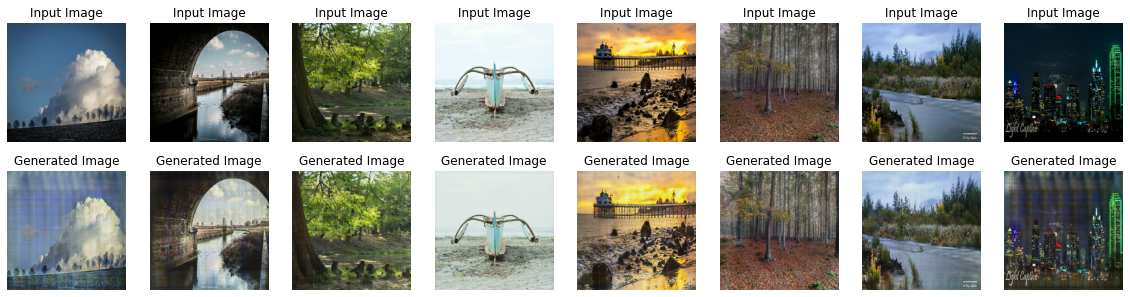

In [23]:
view_generated(default_generator, 8)

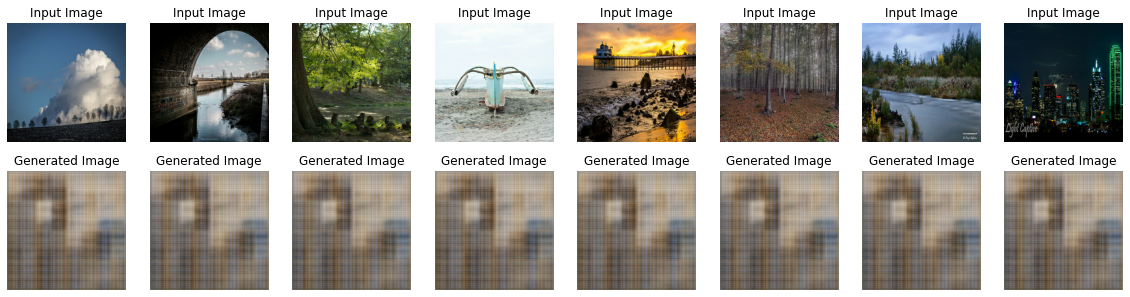

In [24]:
view_generated(no_skip_generator, 8)

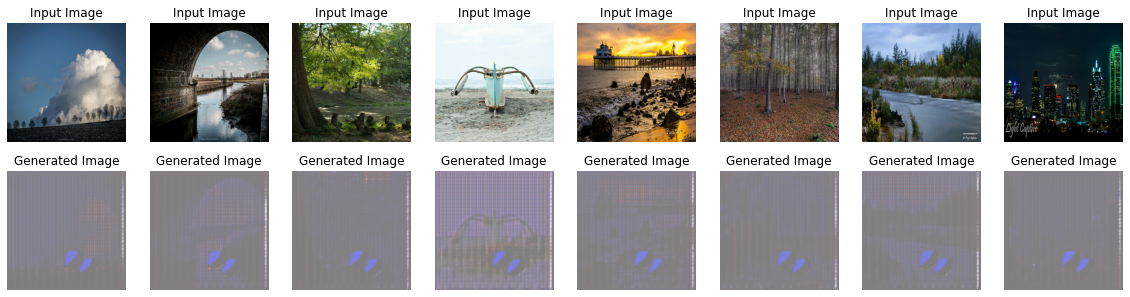

In [25]:
view_generated(sigmoid_generator, 8)

As we can see, the default model, utilizing tried-and-true configurations, consistently produced the best results. The generated images closely resemble the original images, but there are noticeable differences in image's features. We can see lighter overall coloring and more stylized markings and blending throughout. With a longer training duration,I think that more distinct features of Monet's style would have started to show through in these images. In contrast, the model without skip connections exhibited interesting behavior, producing identical images for all inputs. I think this is expected, as without skip connections, the generator relies solely on feedback from the last layer of output, resulting in a more generalized approach. Without feedback and full context for how the image looked initially, I think it's likely the model is incrementally adjusting and generating some base image, and not actually applying a transform since it has no context for the original image as a whole. That said I'd be curious to see what that base image evolved into were we to have run more training epochs. Finally, the use of a sigmoid activation function, instead of the default tanh also gave some interesting results. While general features emerged in the generated images, the color and style were still not as evolved as compared to the default model. This configuration may converge faster than the model without skip connections, but its performance is not as quick as the default model.
Additionally, it is worth noting that the patch structure of the PatchGAN discriminator is visible in many of the generated images. This is characterized by distinct lines and sections in the images, suggesting that the PatchGAN architecture is influencing the style of the generated images.

# Step Five: Conclusions

In conclusion, this experimentation with different configurations of the CycleGAN model provided valuable insights into their impact on the generation of stylized images. The default model, with its traditional configurations, consistently produced the best results, closely resembling the original images but with noticeable stylistic differences. The model without skip connections highlights the importance of providing additioanly context to the generator in order to capture characteristics specific to each input image. And finally, the use of different activation functions displays the importance of choosing the right activation function for a model. I would be very curious to see how various activation models compared to the ones used here. As additional possible future work, I think it'd be interesting to run all configurations for more epochs to observe further evolution and convergence.

## Kaggle submission code

In [26]:
# import PIL
# ! mkdir ../images

In [27]:
# i = 1
# for img in photo_data:
#     prediction = default_generator(img, training=False)[0].numpy()
#     prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
#     im = PIL.Image.fromarray(prediction)
#     im.save("../images/" + str(i) + ".jpg")
#     i += 1

In [28]:
# import shutil
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")